# Data Preprocessing

"LOB" usually refers to "Limit Order Book". In the financial markets, a limit order book is a mechanism for recording and ordering buy and sell orders on an exchange or trading platform. Each order specifies a price and quantity. Buy orders (the price at which to buy) will be listed in descending order, while sell orders (the price at which to sell) will be listed in descending order. This helps the trader to understand the supply and demand situation in the market, as well as the possible direction of price movements.

"Tape" in finance usually refers to "Ticker Tape", an early form of telegraph technology used to transmit information about stock prices and trading volume. The modern meaning extends to any form of real-time trading data transmission. Tape" is often used to refer to trading activity and data flow in the marketplace, especially the real-time quotes and transaction details of stock trades.

In short, LOB provides traders with an overview of current buy and sell orders in a market, while Tape provides real-time data on trade execution. Both are important tools for understanding and analyzing financial market dynamics.

# 1. Read LOB and Tape files
The LOB and Tape files are stored in the "LOBs" and "Tapes" folders, respectively. Each file contains a series of records, each of which is a JSON object. The JSON object contains the following fields:
- LOB file: Timestamp, Exchange, Orders(bid and ask orders)
- Tape file: Timestamp, Price, Volume

The first step is to read the LOB and Tape files and convert them into a structured format, such as a pandas DataFrame. 

I create a script to combine all of the tape files into a single CSV file, and then read the combined tape file into a pandas DataFrame. However, the LOB files are too large to be loaded into memory at once, so I first read one LOB file and then use it to check the data structure.


In [8]:
import pandas as pd
import numpy as np
import  sklearn
import os
import json
import ast  

## 1.1 Tape file
The whole datasets are too large to be loaded into memory at once. Therefore, we try to first load one tape to make some data wrangling and then create a baseline model.

In [66]:
# read the combined tape file
tape_data = pd.read_csv('./datasets/tape_data.csv')
tape_data.head()

# read one tape file as an examplem
# set the column names
tape1 = pd.read_csv('./datasets/UoB_Set01_2025-01-02tapes.csv', names=["Timestamp", "Price", "Volume"])

## 1.2 LOB file
Because the LOB files are txt files, we need to read them line by line and then convert them into a DataFrame.

In [3]:
# create a function to parse the LOB entry,which means to extract the timestamp, exchange, and orders
def parse_lob_entry(entry):
    timestamp, exchange, orders = entry
    bids = orders[0][1]  
    asks = orders[1][1]  
    return timestamp, exchange, bids, asks

# read the lob using the parse_lob_entry function and read_lines
def read_lob_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines() 
        lob_data = []
        for line in lines:
            # replace single quotes with double quotes and ensure that internal double quotes are properly escaped
            fixed_line = line.replace("'", '"').replace('Exch0', '"Exch0"')
            lob_data.append(json.loads(fixed_line))
    return pd.DataFrame(lob_data, columns=["Timestamp", "Exchange", "Orders"])

file_path = './datasets/UoB_Set01_2025-01-02LOBs.txt'  
lob_data = read_lob_file(file_path)

print(lob_data.head())

   Timestamp Exchange                                Orders
0      0.000    Exch0                [[bid, []], [ask, []]]
1      0.279    Exch0          [[bid, [[1, 6]]], [ask, []]]
2      1.333    Exch0  [[bid, [[1, 6]]], [ask, [[800, 1]]]]
3      1.581    Exch0  [[bid, [[1, 6]]], [ask, [[799, 1]]]]
4      1.643    Exch0  [[bid, [[1, 6]]], [ask, [[798, 1]]]]


As we can see, there are much information in the Orders column. We need to expand the Orders column to extract the bid and ask prices and quantities.

In [7]:
# create a function to parse the Orders column
# add new columns to the DataFrame for the bid and ask prices and quantities
def expand_orders(df):
    # initialize lists to store the expanded data
    bid_prices, bid_quantities, ask_prices, ask_quantities = [], [], [], []

    # iterate over the DataFrame rows
    for index, row in df.iterrows():
        # set the default values to None, in case the row is empty
        bid_price = bid_quantity = ask_price = ask_quantity = None

        # extract the bid and ask lists from the Orders column
        bids = row['Orders'][0][1] 
        asks = row['Orders'][1][1]  

        if bids:  
            bid_price, bid_quantity = bids[0]  # extract the price and quantity of the first bid

        if asks: 
            ask_price, ask_quantity = asks[0]  # extract the price and quantity of the first ask

        # append the extracted values to the lists
        bid_prices.append(bid_price)
        bid_quantities.append(bid_quantity)
        ask_prices.append(ask_price)
        ask_quantities.append(ask_quantity)

    # add the expanded columns to the DataFrame
    df['Bid Price'] = bid_prices
    df['Bid Quantity'] = bid_quantities
    df['Ask Price'] = ask_prices
    df['Ask Quantity'] = ask_quantities

    return df

lob_data_expanded = expand_orders(lob_data)
print(lob_data_expanded.head())

   Timestamp Exchange                                Orders  Bid Price  \
0      0.000    Exch0                [[bid, []], [ask, []]]        NaN   
1      0.279    Exch0          [[bid, [[1, 6]]], [ask, []]]        1.0   
2      1.333    Exch0  [[bid, [[1, 6]]], [ask, [[800, 1]]]]        1.0   
3      1.581    Exch0  [[bid, [[1, 6]]], [ask, [[799, 1]]]]        1.0   
4      1.643    Exch0  [[bid, [[1, 6]]], [ask, [[798, 1]]]]        1.0   

   Bid Quantity  Ask Price  Ask Quantity  
0           NaN        NaN           NaN  
1           6.0        NaN           NaN  
2           6.0      800.0           1.0  
3           6.0      799.0           1.0  
4           6.0      798.0           1.0  


# 2. Data Wrangling
## 1.1 Tape file
The tape file contains the following fields:
- Timestamp: the time at which the trade occurred
- Price: the price at which the trade occurred
- Volume: the number of shares traded

### 1. Check the data type
The original data type may use more memory than necessary. We can convert the data type to a more memory-efficient format.

For Timestamp column, we may need to convert it to datetime later.

In [36]:
tape_data['Timestamp'] = tape_data['Timestamp'].astype('float32')
tape_data['Price'] = tape_data['Price'].astype('int32')  
tape_data['Volume'] = tape_data['Volume'].astype('int32')  

print(tape_data.dtypes)

Timestamp    float32
Price          int32
Volume         int32
dtype: object


### 2. Check NA values
We can see that there is no missing value in the tape file. 

In [38]:
# check for missing values
print(tape_data.isna().sum())

Timestamp    0
Price        0
Volume       0
dtype: int64


### 3. Check outliers


In [40]:
# check for outliers
pd.set_option('display.float_format', '{:.2f}'.format)
print(tape_data.describe())

       Timestamp      Price     Volume
count 3340501.00 3340501.00 3340501.00
mean    15336.86     200.51       2.01
std      8816.72      80.10       1.15
min         0.68      93.00       1.00
25%      7690.60     136.00       1.00
50%     15349.96     172.00       2.00
75%     22976.39     284.00       3.00
max     30599.98     397.00       5.00


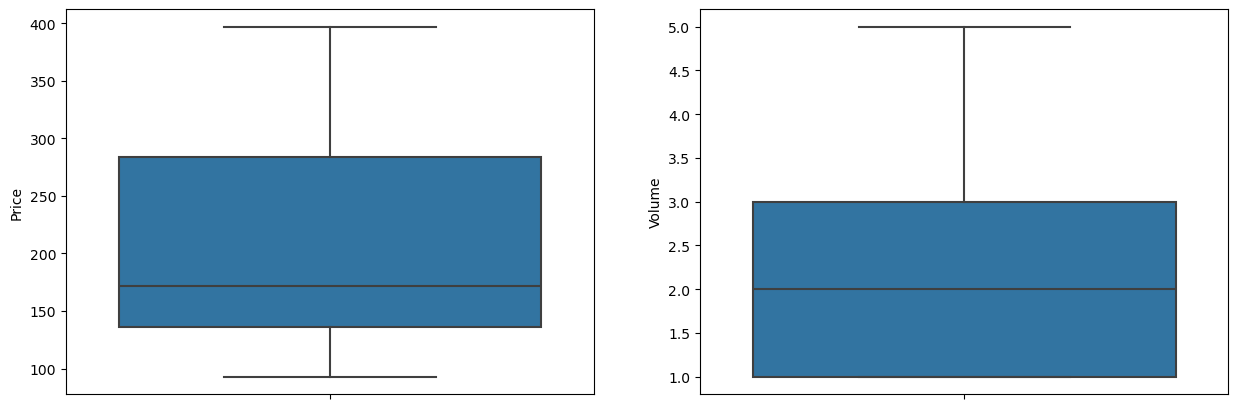

In [44]:
# plot the boxplot of the price and volume
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y='Price', data=tape_data, ax=ax[0])
sns.boxplot(y='Volume', data=tape_data, ax=ax[1])
plt.show()

From the Boxplot and the describe table, we can see that there are no outliers in the price and volume columns.

# 3. EDA
## 3.1 Tape file
First plot the histogram of the price and volume to see the distribution of the data.

E:\Programming\anaconda3\envs\mytorch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


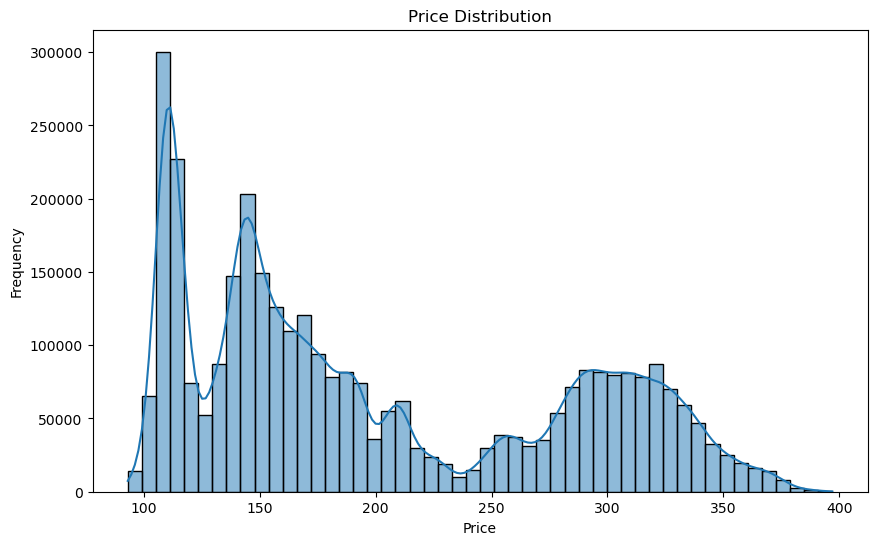

In [55]:
# Histogram of the price for the combined tape file
plt.figure(figsize=(10, 6))
sns.histplot(tape_data['Price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

This histogram displays the distribution of prices, from which we can observe several characteristics:

- **Multi-modal Distribution**: The presence of several peaks in the graph may indicate concentrations of price distributions within different ranges, or it might represent the existence of different groups or categories within the data.

- **Asymmetry**: The distribution appears to be asymmetrical. Some peaks are steeper or flatter than others, suggesting that the data distribution might be skewed.

- **Potential Outliers**: There are lower frequencies of prices in some higher ranges, which could be high-value transactions that are outliers.

In summary, the histogram of this price distribution indicates that the dataset has varying concentrations across different price ranges. The shape and peaks of the distribution provide clues for further statistical analysis. For instance, analyzing the specific transaction types corresponding to each peak or market conditions, or further investigating the potential causes behind this distribution.

E:\Programming\anaconda3\envs\mytorch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


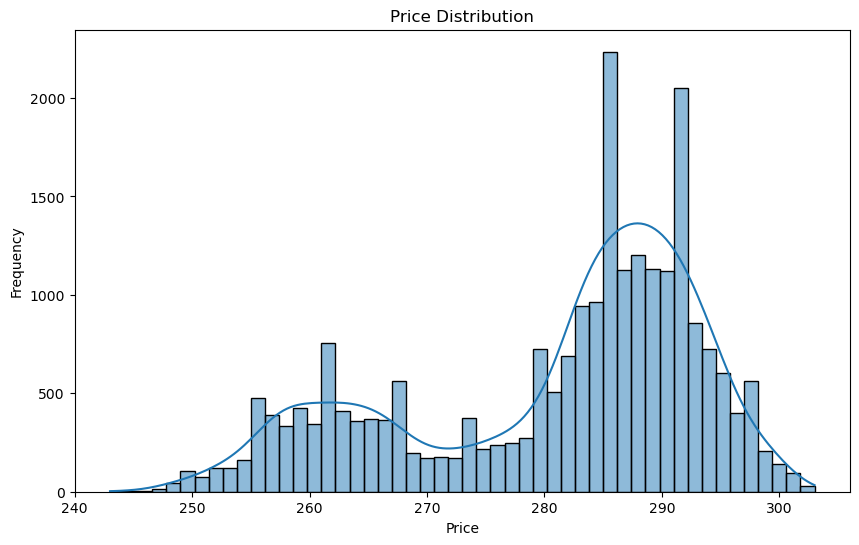

In [56]:
# Histogram of the volume for one tape file
plt.figure(figsize=(10, 6))
sns.histplot(tape1['Price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### Time Series Chart

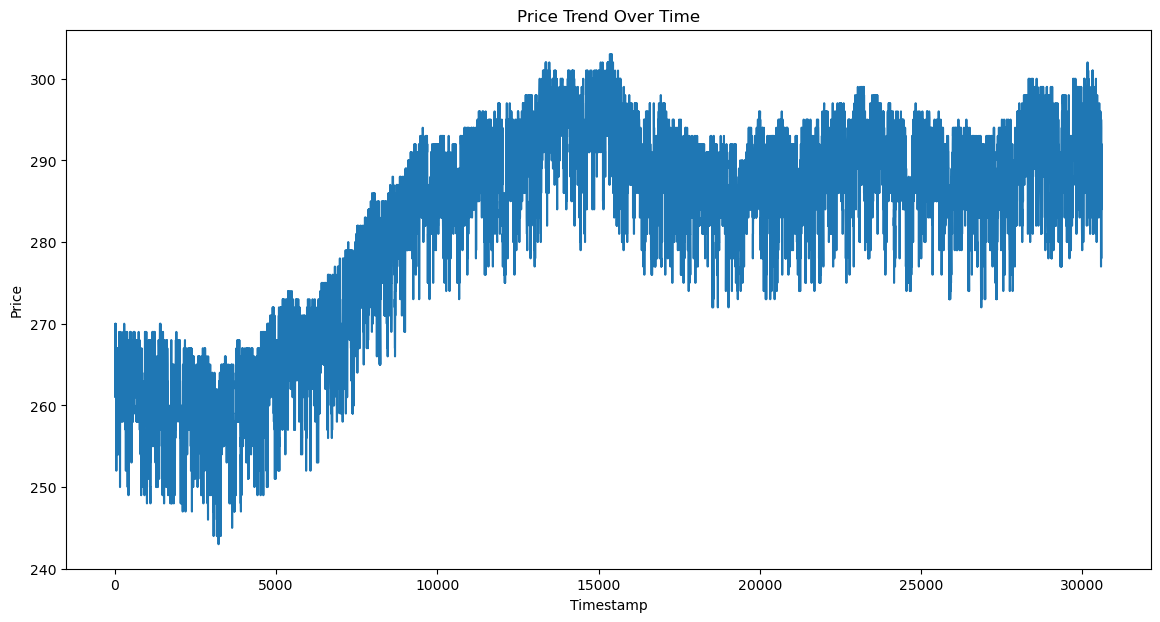

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(tape1['Timestamp'], tape1['Price'])
plt.title('Price Trend Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.show()


# 移动平均值